In [6]:
import os
import pandas as pd
from pandas import DataFrame,Series
from sklearn import tree
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
# !pip install statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import neighbors
from sklearn import linear_model
import sklearn
import autosklearn.regression
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0,'/home/unibas/boittier/fdcm_python/')

from fdcm_python import *

def scale_min_max(data, x):
    # print(data)
    # print(x)
    return (x - data.min())/(data.max() - data.min())

def inv_scale_min_max(x, dmin, dmax):
    return x * (dmax - dmin) + dmin
    
    
def scale_Z(data, x):
    # print(data)
    # print(x)
    return (x - data.mean())/(data.std())

def inv_scale_Z(x, dmean, dstd):
    return x * dstd + dmean

def evaluate_rmse(structure_key, results):
    from fdcm_python import mdcm
    
    local_pos = []

    for i in range(30):
        key = results[0][i]
        model = results[1][i]
        min_max = results[2][i]
        result = inv_scale_min_max(model.predict([uptri_df.loc[structure_key]]), min_max[0], min_max[1])
        local_pos.append(result)

    
    mdcm_obj = mdcm_set_up([structure_key], first=False, local_pos=None)
    
    initial_rmse = mdcm_obj.get_rmse()
    
    clcl = mdcm_obj.mdcm_clcl
    charges = clcl.copy()
    new_clcl = get_clcl(local_pos, charges)
    
    mdcm_obj.dealloc_all()
    
    # mdcm_obj.set_clcl(new_clcl)
    
    mdcm = mdcm_set_up([structure_key], first=False, local_pos=new_clcl)
    final_rmse = mdcm.get_rmse()
    
    # Write MDCM global from local and Fitted ESP cube files
    mdcm.write_cxyz_files()
    mdcm.write_mdcm_cube_files()
    
    print("{} {:.2f} {:.2f}".format(structure_key, initial_rmse, final_rmse))
    
    mdcm.dealloc_all()
    
    # return #initial_rmse, final_rmse

df_name = "/home/unibas/boittier/fdcm_python/data/dataframes/fmdcm_t1.obj"
df = pd.read_pickle(df_name)
lcs_df = pd.DataFrame(dict(df["lcs"])).T
rename = {i: f"q{i//3}ax{i%3}" for i in range(30)}
lcs_df.rename(columns=rename, inplace=True)
uptri_df = pd.DataFrame(dict(df["uptriDM"])).T


In [2]:
# graph_pkl = "/home/unibas/boittier/fdcm_project/mdcms/methanol/H.obj" 
# G = pd.read_pickle(graph_pkl)

# def get_neighbours_weights(i):
#     edges = G.edges(2495)
#     e_node = []
#     e_weight = []
#     for e in edges:
#         e_node.append(e[1])
#         e_weight.append(G.get_edge_data(*e)["weight"])
    
#     return (e_node, e_weight)



In [3]:

# df

In [4]:
def run_regression(df_name, alpha=1e-5, plot = False, test_size=0.5):

    df = pd.read_pickle(df_name)

    lcs_df = pd.DataFrame(dict(df["lcs"])).T
    rename = {i: f"q{i//3}ax{i%3}" for i in range(30)}
    lcs_df.rename(columns=rename, inplace=True)
    uptri_df = pd.DataFrame(dict(df["uptriDM"])).T

    X = uptri_df

    RANDSTATE = 0
    
    models = []
    scale_parms = []
    r2 = []
    keys = lcs_df.keys()
    
    # a kernel for each axis of each charge 
    for key in keys:
        
        y = lcs_df[key]
        
        y = scale_min_max(y,y)

        X_train, X_test, y_train, y_test = \
            sklearn.model_selection.train_test_split(X, y, test_size=test_size, random_state=RANDSTATE)

        kernel = RBF() 
        method = KernelRidge #GaussianProcessRegressor
        model = KernelRidge(
            alpha=alpha,
            kernel=kernel,
            # random_state=RANDSTATE
        ).fit(X_train, y_train)

        # model = Ridge(alpha=1.0).fit(X_train, y_train)
        # model = KernelRidge(alpha=1.0, kernel=kernel).fit(X_train, y_train)

        # print(key)
        train_predictions = model.predict(X_train)
        # print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))

        test_predictions = model.predict(X_test)
        r2_test = sklearn.metrics.r2_score(y_test, test_predictions)
        # print("Test R2 score:", r2_test)
        
        models.append(model)
        scale_parms.append((lcs_df[key].min(), lcs_df[key].max()))
        
        r2.append(r2_test)

        if plot:

            plt.scatter(train_predictions, y_train, label="Train samples", c='#d95f02')
            plt.scatter(test_predictions, y_test, label="Test samples", c='#7570b3')
            plt.xlabel("Predicted value")
            plt.ylabel("True value")
            plt.legend()

            xmin = 0 #min(train_predictions)
            xmax = 1 #max(train_predictions)

            plt.plot([xmin, xmax], [xmin, xmax], c='k', zorder=0)
            plt.xlim([xmin, xmax])
            plt.ylim([xmin, xmax])
            plt.title(key)

            plt.tight_layout()
            plt.gca().set_aspect('equal')
            plt.show()
            
    return keys, models, scale_parms, r2, X_test, X_train



In [5]:
df_name = "data/fmdcm_t1.obj"
results_t1 = run_regression(df_name, alpha=5e-5, plot = False)

In [6]:
df_name = "data/fmdcm_t2.med.obj"
results_t2_med = run_regression(df_name, alpha=5e-5, plot = False)

In [7]:
# df_name = "data/fmdcm_t2.mean.obj"
# results_t2_mean = run_regression(df_name, alpha=5e-5, plot = False)

In [6]:
X_train_indices = list(results_t1[5].index)
# print(X_train_indices)
X_test_indices = list(results_t1[4].index)
print(X_test_indices)

[1763, 865, 269, 1619, 947, 248, 894, 1282, 2160, 737, 1814, 2234, 1854, 924, 394, 1013, 1354, 70, 1647, 2128, 2291, 871, 1853, 562, 1178, 202, 1357, 266, 2256, 2325, 1181, 1529, 731, 1615, 1008, 1272, 4, 1387, 1944, 87, 817, 864, 1685, 516, 1673, 1919, 1403, 120, 632, 1606, 2391, 278, 1579, 1266, 1334, 714, 603, 1009, 1208, 1280, 1423, 664, 1743, 2465, 2322, 1694, 475, 1283, 1442, 416, 2238, 1516, 343, 1541, 2219, 1890, 1654, 321, 314, 160, 1300, 1509, 2327, 1091, 2394, 2355, 496, 296, 1355, 124, 503, 1682, 2444, 1778, 1106, 384, 1550, 1744, 1097, 726, 835, 958, 960, 1674, 197, 1677, 1591, 2454, 2324, 481, 485, 1306, 2280, 361, 916, 2039, 1262, 1124, 724, 1331, 2232, 2347, 1478, 2343, 179, 1006, 1248, 1397, 284, 2079, 2300, 1553, 1093, 294, 408, 435, 1576, 1332, 624, 2055, 1816, 2166, 351, 712, 426, 2351, 1250, 1142, 1508, 2002, 1979, 750, 1084, 1793, 139, 2216, 1659, 1856, 1456, 1639, 1053, 1480, 497, 2491, 221, 2121, 2377, 91, 1996, 226, 1117, 2117, 463, 1887, 1218, 931, 501, 739, 5

In [7]:
# # initial_rmsd = []
# # final_rmsd = []

# for i in X_test_indices[-100:]:
#     evaluate_rmse(i, results_t1)
#     # initial, final = evaluate_rmse(i, results_t1)
#     # initial_rmsd.append(initial)
#     # final_rmsd.append(final)

In [ ]:
for i in X_test_indices[:]:
    evaluate_rmse(i, results_t1)

1763 1.01 0.68
865 0.79 0.57


In [ ]:
for i in X_test_indices[:]:
    evaluate_rmse(i, results_t2_med)

1763 1.01 0.59
865 0.79 0.52


In [17]:
evaluate_rmse(202, results_t1)

predicted local charges
predicted initial rmse
202 1.17 0.65


In [6]:
for i in df.index[1:2]:
    evaluate_rmse(i, results_t1)

predicted local charges
predicted initial rmse
1001 1.17 0.60


In [7]:
for i in df.index[:1]:
    evaluate_rmse(i, results_t1)

predicted local charges
predicted initial rmse
1000 1.59 0.78


In [ ]:
for i in df.index[2:4]:
    evaluate_rmse(i, results_t1)

(0.0, 1.0)

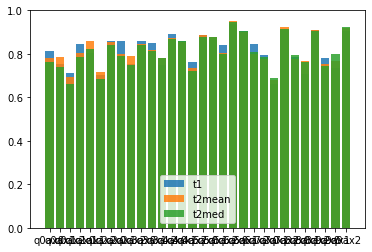

In [265]:
plt.bar(results_t1[0], results_t1[3], label="t1", alpha=0.85)
plt.bar(results_t2_mean[0], results_t2_mean[3], label="t2mean", alpha=0.85)
plt.bar(results_t2_med[0], results_t2_med[3], label="t2med", alpha=0.85)
plt.legend(loc=8)
plt.ylim(0,1)

In [8]:
evaluate_rmse(1000, results_t1)

predicted local charges
predicted initial rmse
1000 1.59 0.78


In [ ]:
evaluate_rmse(1001, results_t1)

In [1]:



    
    # mdcm.dealloc_all()
    